In [1]:
%load_ext autoreload
%autoreload 2

# Existing solution
references: https://pubs.acs.org/doi/10.1021/acsami.4c01401

### *None of 6 models surpasses the 90% accuracy.* 
<img src="../data/polymer/am4c01401_si_001.png" alt="model results" />
Figure 3. (a) Images of the prediction performance of ML using three types of linear regressions and three types of nonlinear regressions. (b) R2 and RMSE values of each algorithm in predicting the amount of adsorbed protein. Values for test data are shown with diagonal lines.

# My Active Learning approach

# 1. Load libraries

In [2]:
import os
os.chdir('../')

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

/Users/gbemidebe/miniconda3/envs/ActiveLearn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"
                                                ] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 13
plt.rcParams['figure.dpi'] = 300

In [5]:
# fix random seed
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.enabled = False

In [6]:
from src.query import RandomSampling, LeastConfidence, MarginSampling, EntropySampling, \
                             LeastConfidenceDropout, MarginSamplingDropout, EntropySamplingDropout, \
                             KMeansSampling, KCenterGreedy, BALDDropout, \
                             AdversarialBIM, AdversarialDeepFool
from src.preprocessing import Handler, Data
from src.network import Net, Regressor

# 2. Load Data

In [7]:
data = pd.read_excel('./data/polymer/am4c01401_si_001.xlsx')
data.drop(columns=['Ref.'], inplace=True)
data.head()

,Protein Adsorption (ng/cm2),Mn,Density,Thickness,Sub_Ad,pH,Temp,Pro_Conc,Ionic strength,Flow rate,Pol_Type,Mpro,Charge
0,1800.0,12000,0.74,11.04,3350.0,7.4,37,1.00,150,0.0,5.8,66000,-2.4
1,3100.0,12000,0.14,2.15,3350.0,7.4,37,1.00,150,0.0,5.8,66000,-2.4
2,220.0,12200,0.10,1.50,410.0,7.4,23,0.05,150,0.0,9.4,340000,-1.6
3,160.0,12200,0.14,2.00,410.0,7.4,23,0.05,150,0.0,9.4,340000,-1.6
4,50.0,12200,0.29,4.40,410.0,7.4,23,0.05,150,0.0,9.4,340000,-1.6


In [8]:
data.dtypes

Protein Adsorption (ng/cm2)    float64
Mn                               int64
Density                        float64
Thickness                      float64
Sub_Ad                         float64
pH                             float64
Temp                             int64
Pro_Conc                       float64
Ionic strength                   int64
Flow rate                      float64
Pol_Type                       float64
Mpro                             int64
Charge                         float64
dtype: object

In [9]:
features_col = data.columns[1:]
target_col = data.columns[0]
print('Features: ', features_col)
print('Target: ', target_col)

Features:  Index(['Mn', 'Density', 'Thickness', 'Sub_Ad', 'pH', 'Temp', 'Pro_Conc',
       'Ionic strength', 'Flow rate', 'Pol_Type', 'Mpro', 'Charge'],
      dtype='object')
Target:  Protein Adsorption (ng/cm2)


Text(0, 0.5, 'Frequency')

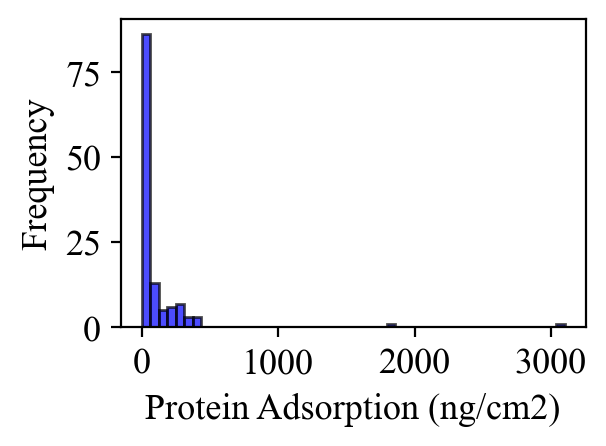

In [10]:
# data description
plt.figure(figsize=(3, 2), dpi=200)
# histogram using matplotlib
k = plt.hist(data[target_col], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel(target_col)
plt.ylabel('Frequency')

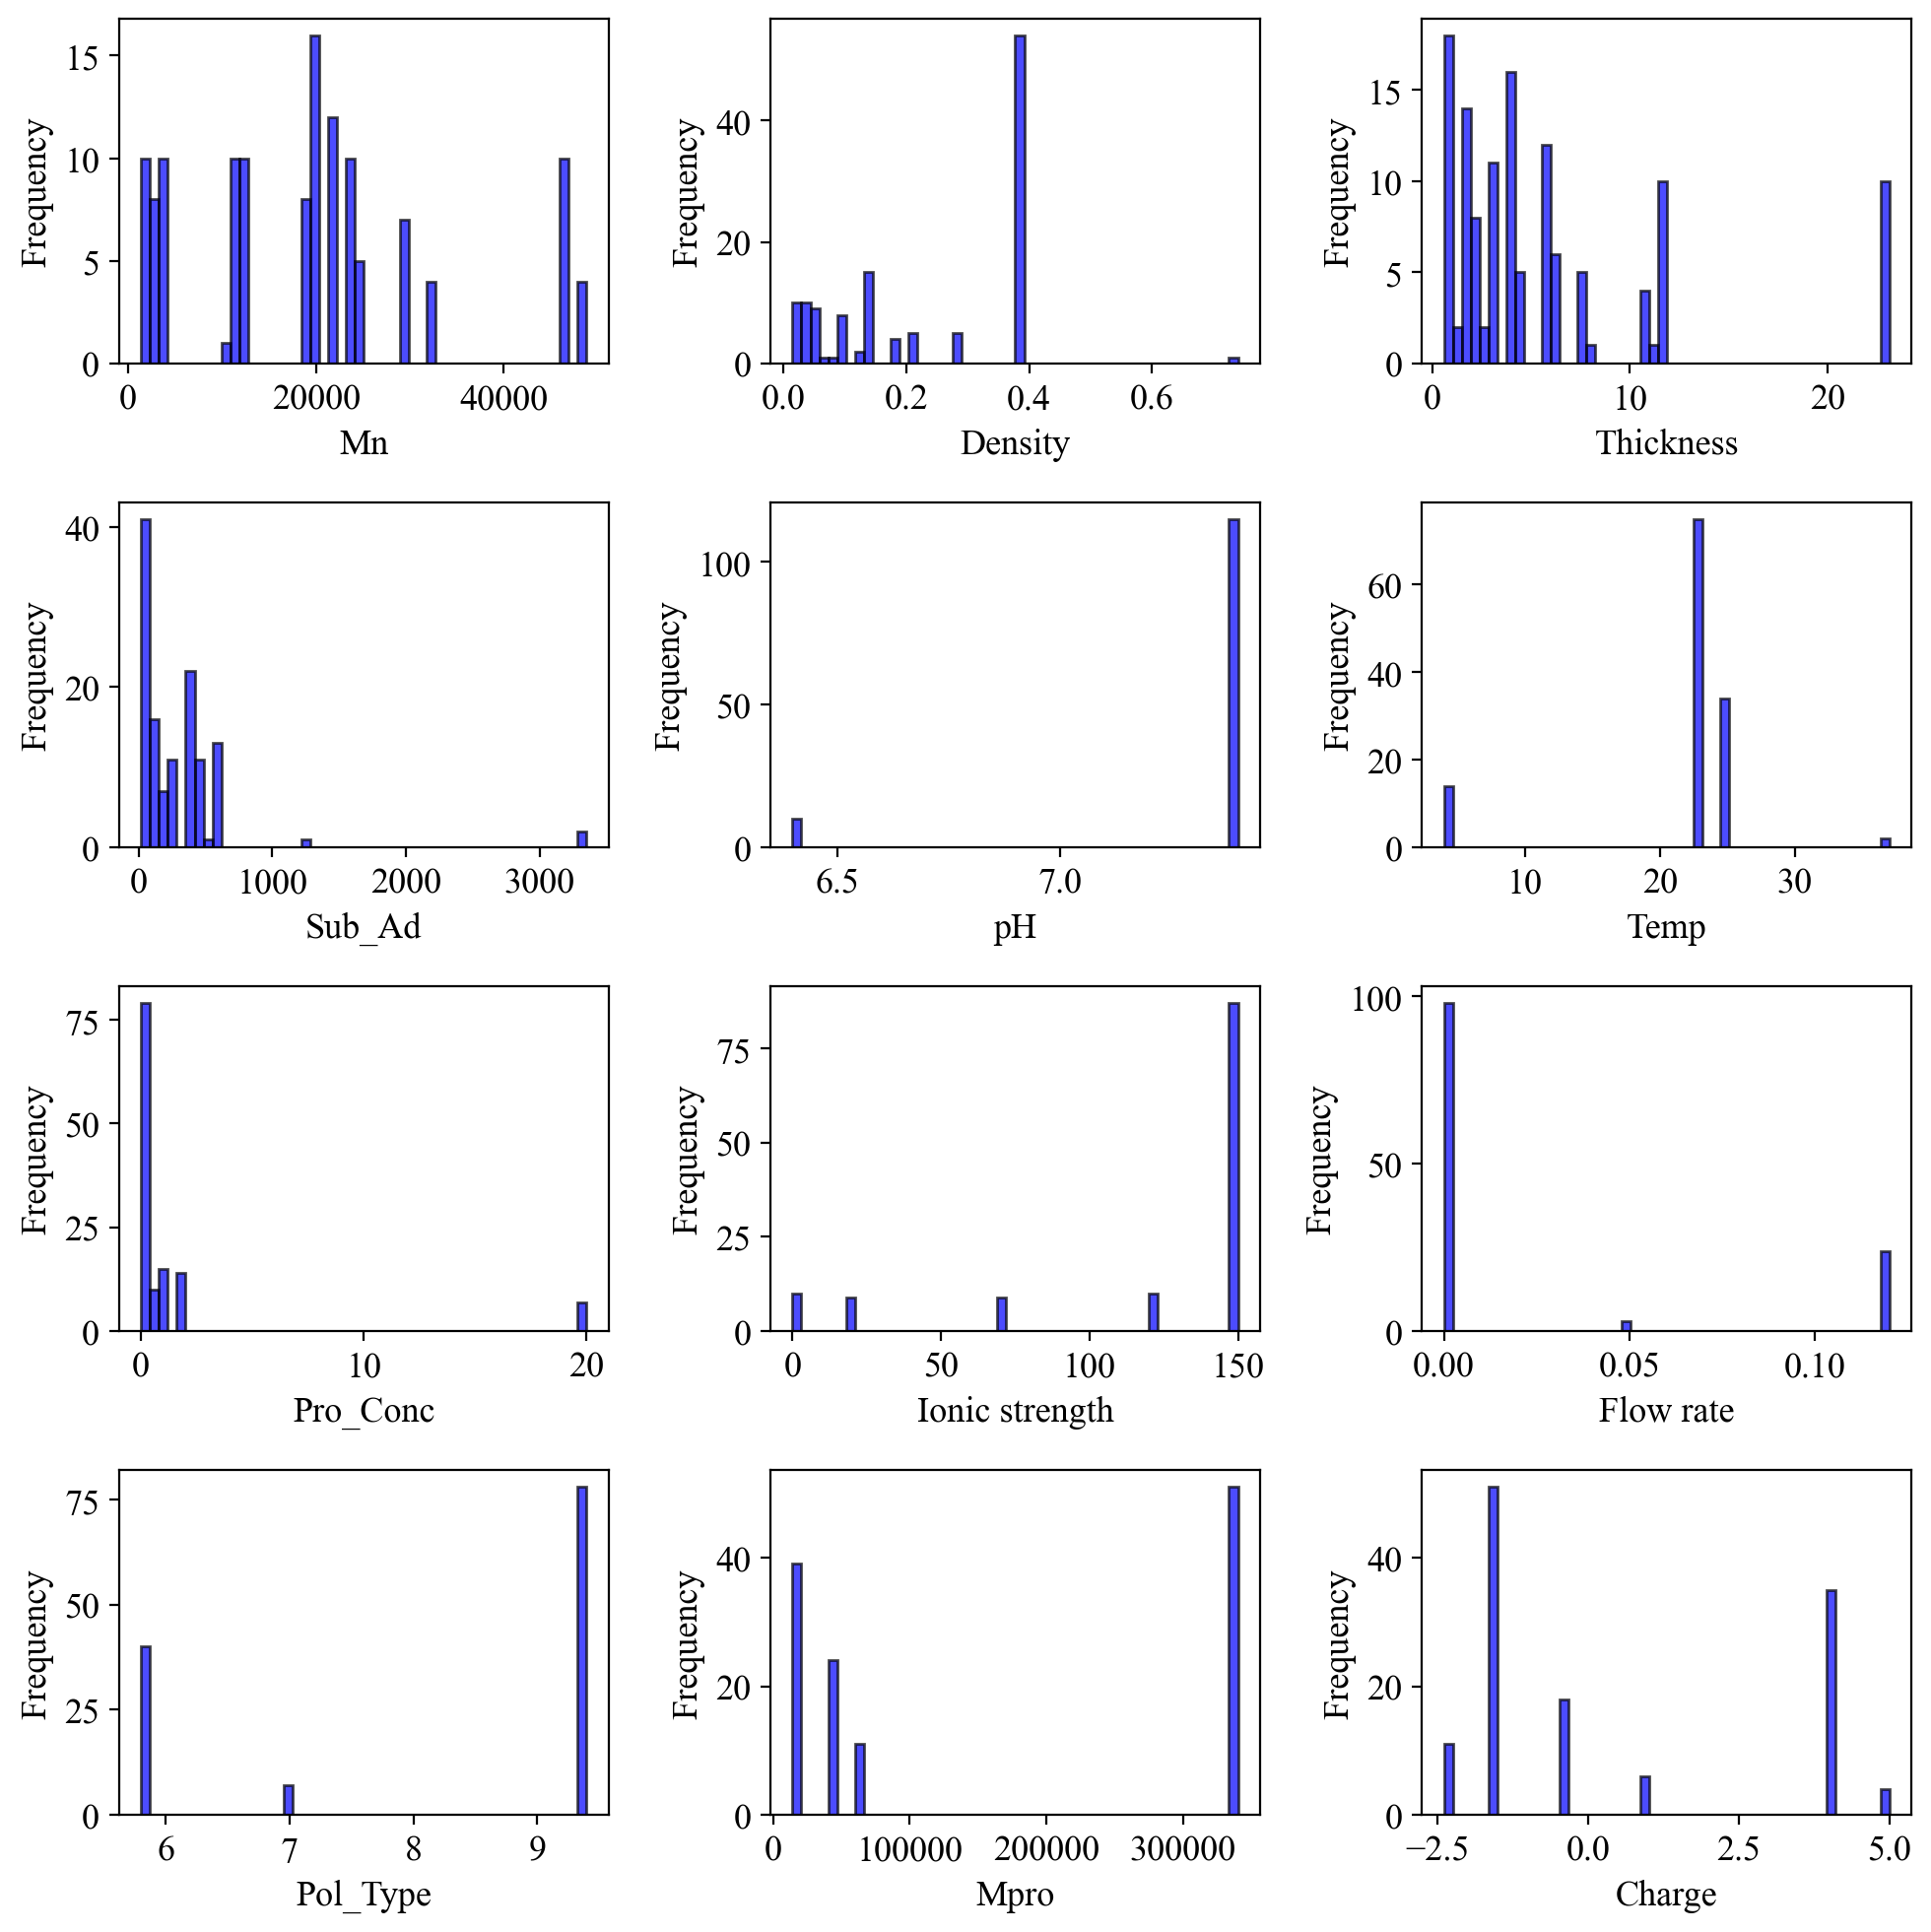

In [11]:
# show histogram for all features with subplots
plt.figure(figsize=(10, 10), dpi=200)
for i, feature in enumerate(features_col):
    plt.subplot(4, 3, i+1)
    k = plt.hist(data[feature], bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()

# 3. Model Training

In [12]:
dataset = Data(data, features_col, target_col, test_size=0.2, random_state=42, handler=Handler)

Scaling the data
Splitting the data


In [13]:
# params
params =  {'n_epoch': 100, 
               'train':{'batch_size': 32},
               'test':{'batch_size': 32},
               'optim':{'lr': 0.001, 'amsgrad': False}}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net =  Net(net=Regressor(input_dim=len(features_col), n_hidden_size=32),
           params=params, device=device)
           
print(net)

In [14]:
# the strategy to query the data
strategy = RandomSampling(dataset, net)  # load strategy

In [15]:
# start experiment
n_init_labeled = 10
dataset.initialize_labels(n_init_labeled)
print(f"number of labeled pool: {n_init_labeled}")
print(f"number of unlabeled pool: {dataset.n_pool - n_init_labeled}")
print(f"number of testing pool: {dataset.n_test}")
print()

number of labeled pool: 10
number of unlabeled pool: 90
number of testing pool: 25



In [16]:
# first training
strategy.train()

100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1679.43it/s]


In [17]:
preds_train = strategy.predict(dataset.get_train_data()[1])
preds_test = strategy.predict(dataset.get_test_data())

In [18]:
# unravel append numpy
def unraveled(preds):
    return np.concatenate(preds).ravel()
# calculate r2 score
def acc(dd):
    ''' dd contains the predicted values, true values, mean losses'''
    return r2_score(unraveled(dd[1]), unraveled(dd[0]))
def rmse(dd):
    ''' dd contains the predicted values, true values, mean losses'''
    return mean_squared_error(unraveled(dd[1]), unraveled(dd[0]), squared=False)
def mae(dd):
    ''' dd contains the predicted values, true values, mean losses'''
    return mean_absolute_error(unraveled(dd[1]), unraveled(dd[0]))
def evs(dd):
    ''' dd contains the predicted values, true values, mean losses'''
    return explained_variance_score(unraveled(dd[1]), unraveled(dd[0]))

In [19]:
print("Round 0")
n_round = 10
n_query = 8
strategy.train()
preds_train = strategy.predict(dataset.get_train_data()[1])
preds_test = strategy.predict(dataset.get_test_data())
#print(f"Round 0 testing accuracy: {dataset.cal_test_acc(preds)}")
print(f'Round 0 accuracy --> Train: {r2_score(unraveled(preds_train[1]), unraveled(preds_train[0]))} Test: {r2_score(unraveled(preds_test[1]), unraveled(preds_test[0]))}')

for rd in range(1, n_round+1):
    print(f"Round {rd}")

    # get index for new query
    query_idxs = strategy.query(n_query)
    #print(f"Queried indexes: {query_idxs}")
    # update labels
    strategy.update(query_idxs)
    strategy.train()
    # calculate accuracy
    preds_train = strategy.predict(dataset.get_train_data()[1])
    preds_test = strategy.predict(dataset.get_test_data())
    # print accuracy
    print(f'accuracy --> Train: {acc(preds_train):.3f} Test: {acc(preds_test):.3f}')
    print(f'rmse --> Train: {rmse(preds_train):.3f} Test: {rmse(preds_test):.3f}')
    print(f'mae --> Train: {mae(preds_train):.3f} Test: {mae(preds_test):.3f}')
    print(f'evs --> Train: {evs(preds_train):.3f} Test: {evs(preds_test):.3f}')

Round 0


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3096.27it/s]


Round 0 accuracy --> Train: 0.10313016260083174 Test: 0.03383986951526774
Round 1


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2091.57it/s]


accuracy --> Train: 0.101 Test: -0.002
rmse --> Train: 300.328 Test: 356.279
mae --> Train: 77.489 Test: 127.750
evs --> Train: 0.102 Test: 0.015
Round 2


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2383.41it/s]


accuracy --> Train: 0.160 Test: -0.016
rmse --> Train: 290.219 Test: 358.733
mae --> Train: 66.087 Test: 114.100
evs --> Train: 0.165 Test: 0.013
Round 3


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1684.32it/s]


accuracy --> Train: 0.396 Test: 0.124
rmse --> Train: 246.038 Test: 333.129
mae --> Train: 84.616 Test: 137.042
evs --> Train: 0.404 Test: 0.125
Round 4


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1553.42it/s]


accuracy --> Train: 0.803 Test: 0.653
rmse --> Train: 140.655 Test: 209.550
mae --> Train: 70.422 Test: 104.382
evs --> Train: 0.808 Test: 0.653
Round 5


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 667.55it/s]


accuracy --> Train: 0.941 Test: 0.939
rmse --> Train: 76.923 Test: 87.830
mae --> Train: 40.239 Test: 44.492
evs --> Train: 0.942 Test: 0.939
Round 6


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1423.71it/s]


accuracy --> Train: 0.965 Test: 0.960
rmse --> Train: 59.366 Test: 70.958
mae --> Train: 32.206 Test: 42.995
evs --> Train: 0.965 Test: 0.961
Round 7


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1052.81it/s]


accuracy --> Train: 0.972 Test: 0.969
rmse --> Train: 53.266 Test: 62.399
mae --> Train: 31.079 Test: 39.710
evs --> Train: 0.975 Test: 0.969
Round 8


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1101.55it/s]


accuracy --> Train: 0.978 Test: 0.964
rmse --> Train: 47.105 Test: 67.410
mae --> Train: 25.479 Test: 43.437
evs --> Train: 0.978 Test: 0.965
Round 9


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1046.74it/s]


accuracy --> Train: 0.992 Test: 0.981
rmse --> Train: 27.570 Test: 49.442
mae --> Train: 17.710 Test: 32.794
evs --> Train: 0.993 Test: 0.981
Round 10


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1070.20it/s]

accuracy --> Train: 0.995 Test: 0.979
rmse --> Train: 23.224 Test: 51.997
mae --> Train: 14.585 Test: 33.785
evs --> Train: 0.995 Test: 0.980


Text(0, 0.5, '$\\rm Pred \\ Protein \\ Ads. (mg/cm^2)$')

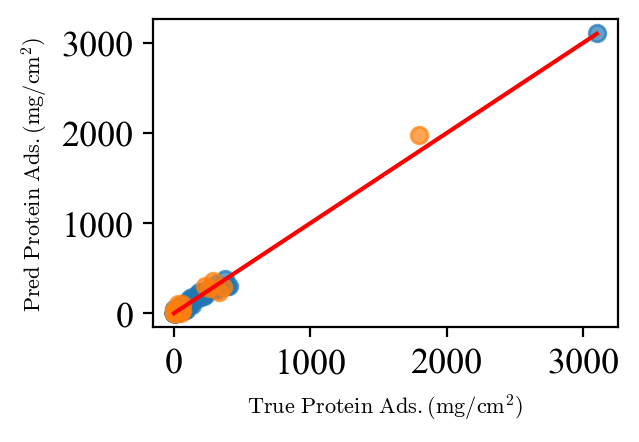

In [20]:
# show model crossplot
plt.figure(figsize=(3, 2), dpi=200)
plt.scatter(unraveled(preds_train[1]), unraveled(preds_train[0]), label=r'$\rm train$', alpha=0.7)
plt.scatter(unraveled(preds_test[1]), unraveled(preds_test[0]), label=r'$\rm test$', alpha=0.7)
# plot 45 degree line, get max and min values
plt.plot([min(data[target_col]), max(data[target_col])], [min(data[target_col]), max(data[target_col])], color='red')
plt.xlabel(r'$\rm True \ Protein \ Ads. (mg/cm^2)$', fontsize=8)
plt.ylabel(r'$\rm Pred \ Protein \ Ads. (mg/cm^2)$', fontsize=8)

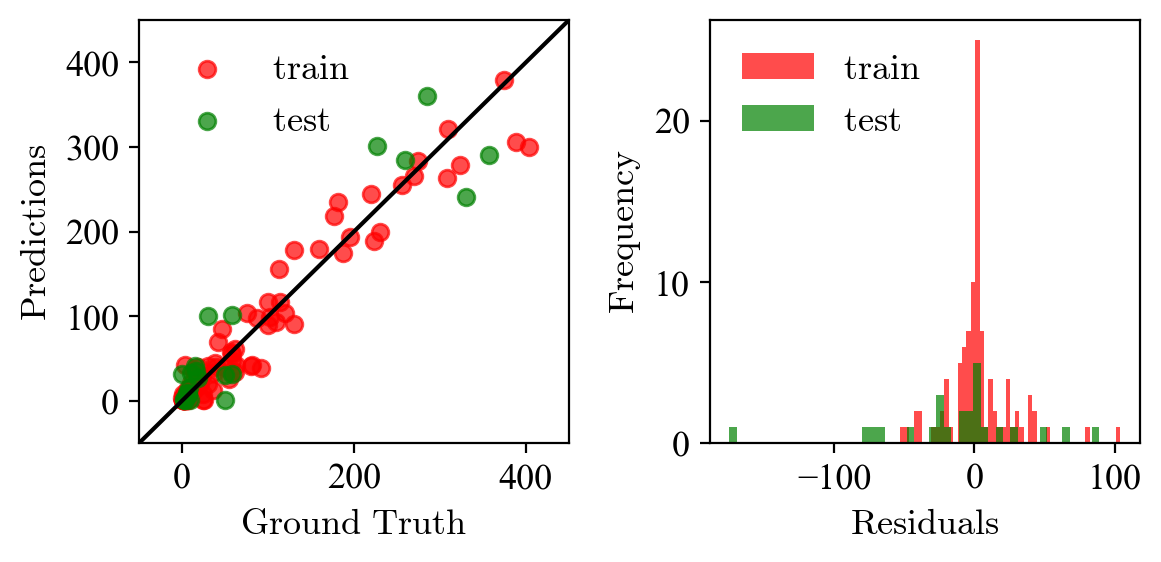

In [21]:
# show model crossplot
fig, axs = plt.subplots(1, 2, figsize=(6, 3), dpi=200)
axs[0].scatter(unraveled(preds_train[1]), unraveled(preds_train[0]), color='red', label=r'$\rm train$', alpha=0.7)
axs[0].scatter(unraveled(preds_test[1]), unraveled(preds_test[0]), color='green', label=r'$\rm test$', alpha=0.7)
# plot 45 degree line, get max and min values
axs[0].plot([-50, 450], [-50, 450], color='black')
axs[0].set_xlabel(r'$\rm Ground \ Truth $')
axs[0].set_ylabel(r'$\rm Predictions $')
# zoom in by removing values beyond 2000
axs[0].set_xlim([-50, 450])
axs[0].set_ylim([-50, 450])
axs[0].legend(frameon=False)

# plot histogram of residuals
axs[1].hist(unraveled(preds_train[1]) - unraveled(preds_train[0]), bins=50, alpha=0.7, color='red')
axs[1].hist(unraveled(preds_test[1]) - unraveled(preds_test[0]), bins=50, alpha=0.7, color='green')
axs[1].set_xlabel(r'$\rm Residuals$')
axs[1].set_ylabel(r'$\rm Frequency$')
axs[1].legend([r'$\rm train$', r'$\rm test$'], frameon=False)

plt.tight_layout()